In [ ]:
# Check GPU setup in Colab
%tensorflow_version 1.x
import tensorflow as tf

# Silence the tensorflow warning message
tf.get_logger().setLevel('ERROR')

# Check GPU coinfiguration in Colab (T4 GPU)
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())
# Your expected output will be '/device:GPU:0'

TensorFlow 1.x selected.
Tensorflow version:  1.15.2



In [ ]:
# Mount your drive
# Run this cell, then you’ll see a link, click on that link, allow access
# Copy the code that pops up, Paste it in the box, Hit enter

from google.colab import drive
drive.mount('/content/gdrive')
# Change working directory to be current folder
import os
os.chdir('/content/gdrive/My Drive/iss/itss/data/baby')
!ls

Mounted at /content/gdrive
climb  climbing.mp4  crawl  lying4.mp4	roll  standing.mp4  walk


In [ ]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import sqrt, pi, arctan2, cos, sin # used for HoF
from scipy.ndimage import uniform_filter # used for hoF
from sklearn import svm

from keras.layers import Activation, Conv3D, Dense, Dropout, Flatten, MaxPooling3D
from keras.losses import categorical_crossentropy
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix


Using TensorFlow backend.


In [ ]:
def load_groups(input_folder,group):
    '''
    Load the list of sub-folders into a python list with their
    corresponding label.
    '''
    groups         = []
    label_folders  = os.listdir(input_folder)
    if os.path.isdir(input_folder):
      group_folders = os.listdir(input_folder)
      for group_folder in group_folders:
          if group_folder != 'Annotation':
              groups.append([os.path.join('/content/gdrive/My Drive/iss/itss/data/baby',input_folder, group_folder), group])

    return groups

#Reference: https://github.com/microsoft/CNTK/blob/master/Examples/Video/DataSets/UCF11/split_ucf11.py
def ucf_split_data(group):
    '''
    Split the data at random for train, eval and test set.
    '''
    group_count = len(group)
    indices = np.arange(group_count)

    np.random.seed(0) # Make it deterministic.
    np.random.shuffle(indices)

    # 80% training and 20% test.
    train_count = int(0.8 * group_count)
    test_count  = group_count - train_count

    train = []
    test  = []

    for i in range(train_count):
        train.append(group[i])

    for i in range(train_count, train_count + test_count):
        test.append(group[i])

    return train, test


In [ ]:
# Prepare the dataset
climb_groups = load_groups("climb",0)
crawl_groups = load_groups("crawl",1)
roll_groups = load_groups("roll",2)
walk_groups = load_groups("walk",3)

In [ ]:
len(climb_groups)

80

In [ ]:
len(crawl_groups)

80

In [ ]:
len(roll_groups)

80

In [ ]:
len(walk_groups)

80

In [ ]:
climb_train, climb_test = ucf_split_data(climb_groups)
crawl_train, crawl_test = ucf_split_data(crawl_groups)
roll_train, roll_test = ucf_split_data(roll_groups)
walk_train, walk_test = ucf_split_data(walk_groups)

In [ ]:
ucf_train = climb_train + crawl_train + roll_train + walk_train

ucf_test = climb_test + crawl_test + roll_test + walk_test

In [ ]:
class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def get_data(self, filename, skip=True):
        cap = cv2.VideoCapture(filename)
        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        bAppend = False
        if (nframe>=self.depth):
            if skip:
                frames = [x * nframe / self.depth for x in range(self.depth)]
            else:
                frames = [x for x in range(self.depth)]
        else:
            print("Insufficient %d frames in video %s, set bAppend as True" % (nframe, filename))
            bAppend = True
            frames = [x for x in range(int(nframe))] # nframe is a float

        framearray = []

        for i in range(len(frames)):#self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            frame = cv2.resize(frame, (self.height, self.width))
            framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        
        if bAppend:
            while len(framearray) < self.depth:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
            print("Append more frames in the framearray to have %d frames" % len(framearray))
                
        return np.array(framearray)

def loaddata(video_list, vid3d, skip=True):
    X = []
    Y = []
    for idx, value in enumerate(video_list):
        # Display the progress
        if (idx % 100) == 0:
            print("process data %d/%d" % (idx, len(video_list)))
        filename = value[0]
        label = value[1]
        Y.append(label)
        X.append(vid3d.get_data(filename, skip=skip))
        
    return np.array(X).transpose((0, 2, 3, 1)), np.array(Y)


In [ ]:
# Define parameter setting
class Args:
    batch = 128
    epoch = 100
    nclass = 4 # 11 action categories
    depth = 10
    rows = 32
    cols = 32
    skip = True # Skip: randomly extract frames; otherwise, extract first few frames

param_setting = Args()
img_rows = param_setting.rows
img_cols = param_setting.cols
frames = param_setting.depth
channel = 1
vid3d = Videoto3D(img_rows, img_cols, frames)
nb_classes = param_setting.nclass


In [ ]:
# Prepare training data
x_train, y_train = loaddata(ucf_train, vid3d, param_setting.skip)
x_train = x_train.reshape((x_train.shape[0], img_rows, img_cols, frames, channel))
y_train = np_utils.to_categorical(y_train, nb_classes)  

# Prepare test data
x_test, y_test = loaddata(ucf_test, vid3d, param_setting.skip)
x_test = x_test.reshape((x_test.shape[0], img_rows, img_cols, frames, channel))
y_test = np_utils.to_categorical(y_test, nb_classes)


process data 0/256
process data 100/256
process data 200/256
process data 0/64


In [ ]:
# Define deep learning model

c3d_model = Sequential()
c3d_model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(x_train.shape[1:]), padding='same'))
c3d_model.add(Activation('relu'))
c3d_model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
c3d_model.add(Activation('softmax'))
c3d_model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
c3d_model.add(Dropout(0.25))

c3d_model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
c3d_model.add(Activation('relu'))
c3d_model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
c3d_model.add(Activation('softmax'))
c3d_model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
c3d_model.add(Dropout(0.25))

c3d_model.add(Flatten(name='flatten_feature'))
c3d_model.add(Dense(512, activation='sigmoid'))
c3d_model.add(Dropout(0.2))
c3d_model.add(Dense(nb_classes, activation='softmax'))

c3d_model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
c3d_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 32, 32, 10, 32)    896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 10, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 10, 32)    27680     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 10, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 11, 11, 4, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 4, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 11, 11, 4, 64)    

In [ ]:
# # Train the model
history = c3d_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=param_setting.batch,
          epochs=param_setting.epoch, verbose=2, shuffle=True)

#c3d_model.save_weights("/content/gdrive/My Drive/iss/itss/data/model_c3d_v0815.h5")

Train on 256 samples, validate on 64 samples
Epoch 1/100
 - 35s - loss: 1.4706 - accuracy: 0.2148 - val_loss: 1.3991 - val_accuracy: 0.2500
Epoch 2/100
 - 34s - loss: 1.4645 - accuracy: 0.2422 - val_loss: 1.4021 - val_accuracy: 0.2500
Epoch 3/100
 - 34s - loss: 1.4576 - accuracy: 0.2461 - val_loss: 1.3878 - val_accuracy: 0.2500
Epoch 4/100
 - 34s - loss: 1.4232 - accuracy: 0.2070 - val_loss: 1.3975 - val_accuracy: 0.2500
Epoch 5/100
 - 34s - loss: 1.4422 - accuracy: 0.2500 - val_loss: 1.3922 - val_accuracy: 0.2500
Epoch 6/100
 - 33s - loss: 1.4444 - accuracy: 0.2539 - val_loss: 1.3877 - val_accuracy: 0.2500
Epoch 7/100
 - 34s - loss: 1.4339 - accuracy: 0.2617 - val_loss: 1.3980 - val_accuracy: 0.2500
Epoch 8/100
 - 34s - loss: 1.4767 - accuracy: 0.2188 - val_loss: 1.3965 - val_accuracy: 0.2500
Epoch 9/100
 - 33s - loss: 1.4192 - accuracy: 0.2617 - val_loss: 1.3873 - val_accuracy: 0.2500
Epoch 10/100
 - 33s - loss: 1.4081 - accuracy: 0.2617 - val_loss: 1.3912 - val_accuracy: 0.2500
Epoc

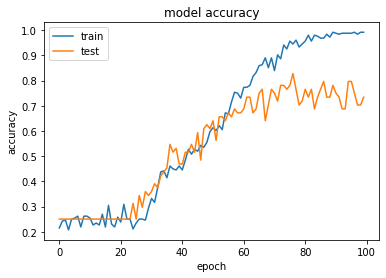

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

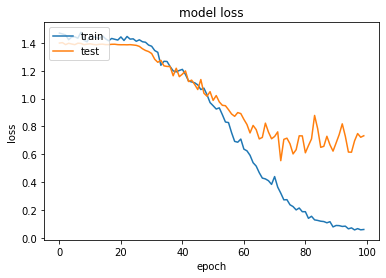

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
c3d_model.save_weights("/content/gdrive/My Drive/iss/itss/data/model_c3d_v2.h5")

In [ ]:
c3d_model.load_weights("/content/gdrive/My Drive/iss/itss/data/model_c3d_v0815.h5")

In [ ]:
# Evaluate the deep learning model
y_pred = c3d_model.predict(x_test, verbose=0)
print("Confusion matrix")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))


Confusion matrix
[[ 9  5  0  2]
 [ 0 11  1  4]
 [ 1  3 11  1]
 [ 0  0  0 16]]


In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

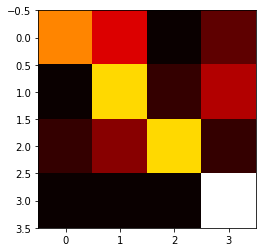

In [ ]:
plt.imshow(cm, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
np.argmax(y_pred, axis=1)

array([3, 3, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 3, 1, 1, 0, 1,
       0, 2, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 3, 0, 3,
       2, 3, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 2, 3, 0,
       3, 3, 3, 1, 3, 1, 1, 2, 1, 3, 0, 3, 3, 2, 2, 3, 0, 1, 3])

In [ ]:
(12+7+14+11)/len(x_test)

0.5176470588235295

In [ ]:
(9+10+15+8)/len(x_test)

0.49411764705882355

In [ ]:
c3d_feature_model = Model(inputs = c3d_model.input, outputs = c3d_model.get_layer('flatten_feature').output)

x_train_features = c3d_feature_model.predict(x_train)

x_train_label = []
for filename, label in ucf_train:
    x_train_label.append(label)

x_train_label = np.array(x_train_label)
print("Training data for c3d_svm_model", x_train_features.shape, x_train_label.shape)

x_test_features = c3d_feature_model.predict(x_test)

x_test_label = []
for filename, label in ucf_test:
    x_test_label.append(label)

x_test_label = np.array(x_test_label)

print("Test data for c3d_svm_model", x_test_features.shape, x_test_label.shape)

c3d_svm_model = svm.SVC(kernel = 'linear', C = 1).fit(x_train_features, x_train_label)

x_test_pred = c3d_svm_model.predict(x_test_features)

print(confusion_matrix(x_test_label, x_test_pred))

Training data for c3d_svm_model (256, 2048) (256,)
Test data for c3d_svm_model (64, 2048) (64,)
[[ 8  4  0  4]
 [ 2  9  1  4]
 [ 1  2 13  0]
 [ 0  0  0 16]]


In [ ]:
(10+9+12+11)/len(x_test)

0.47058823529411764

In [ ]:
type(x_test)

numpy.ndarray

In [ ]:
m_test = vid3d.get_data(filename = '/content/gdrive/My Drive/iss/itss/data/baby/standing.mp4')

In [ ]:
m_test = m_test.reshape((np.array([x_train]).shape[0], img_rows, img_cols, frames, channel))

In [ ]:
result = c3d_model.predict(m_test, verbose=0)

In [ ]:
np.argmax(result, axis=1)

array([0])

In [ ]:
result[0]

0.986439